In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [39]:
pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 7.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Data Preprocessing

In [2]:
# since we have the data across all united states, we have to combine all those files
directory = "D:/uchicago/25 winter/perspective on computational modeling/project 1/census/census"
dataframes = []

# loop
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dataframes.append(df)

# concate all dataframes
census_df = pd.concat(dataframes, ignore_index=True)


# another dataset:
climate_df = pd.read_csv("D:/uchicago/25 winter/perspective on computational modeling/project 1/parks_with_climate_info_by_tract.csv", low_memory = False)

In [3]:
# how many rows for these two datasets
print(census_df.shape)
print(climate_df.shape)

# perform the merge
df = pd.merge(census_df, climate_df, on = 'GEOID', how = 'inner')

(410699, 20)
(65660, 17)


## Exploratory Data Overview

In [4]:
# Data Size
df.shape # how many rows and cols after the merging

(293082, 36)

In [5]:
# Feature Space
## list of numeric cols
numerical_cols = df.select_dtypes(include = np.number).columns.tolist()

## list of categorical cols
categorical_cols = df.select_dtypes(exclude = np.number).columns.tolist()

print(f"Numeric Columns: {numerical_cols}")
print(f"Categorical Columns: {categorical_cols}")
print(f"Number of numeric columns: {len(numerical_cols)}")
print(f"Number of categorical columns: {len(categorical_cols)}")

Numeric Columns: ['GEOID', 'total_popE', 'total_popM', 'race_whiteE', 'race_whiteM', 'race_blackE', 'race_blackM', 'race_asianE', 'race_asianM', 'median_incomeE', 'median_incomeM', 'pov_universeE', 'pov_universeM', 'pov_belowE', 'pov_belowM', 'edu_totalE', 'edu_totalM', 'edu_bachelorE', 'edu_bachelorM', 'LATITUDE', 'LONGITUDE', 'index_right', 'index__climate']
Categorical Columns: ['NAME', 'PLACEKEY', 'LOCATION_NAME', 'STREET_ADDRESS', 'CITY', 'REGION', 'POSTAL_CODE', 'PARENT_PLACEKEY', 'TOP_CATEGORY', 'SUB_CATEGORY', 'County', 'Code', 'Climate']
Number of numeric columns: 23
Number of categorical columns: 13


We have total 36 features  <br>
while it contains 13 categorical columns and 23 numerical columns: <br>

## Handle missing or invalid values + create target variable

In [6]:
# drop the rows that might affect the poverty rate (dependent variable)
df = df[(df['total_popE'] > 0) & (df['pov_universeE'] > 0)]

# drop the na
df.dropna(subset = ['pov_belowE', 'pov_universeE'], inplace = True)

print(df.shape)

(290941, 36)


In [7]:
# Target variable poverty rate
df['pov_rate'] = df['pov_belowE'] / df['pov_universeE']

# data cleanning: remove the out of logical bounds
df = df[(df['pov_rate'] >= 0) & (df['pov_rate'] <= 1)]

print(df.shape) # check whether there is invalid values that is actually removed

(290941, 37)


## Feature Engnieering

In [8]:
# racial proportions
df['pct_white'] = df['race_whiteE'] / df['total_popE']
df['pct_black'] = df['race_blackE'] / df['total_popE']
df['pct_asian'] = df['race_asianE'] / df['total_popE']

# educationcal attainment
df.loc[df['edu_totalE'] == 0, 'edu_totalE'] == np.nan # we should avoid the denominator is zero
df['pct_bachelor'] = df['edu_bachelorE'] / df['edu_totalE']

In [9]:
# since in many regions, median income is right-skewed, therefore we should use log-transform
o_skew = df['median_incomeE'].skew()
print(f"Original skewness of median_incomeE variable: {o_skew:.4f}")

Original skewness of median_incomeE variable: 1.6176


In [ ]:
# since the skew is 1.6176 in the above slot, therefore, we should apply the log-transform
# but i am writing if function in case of being needed to adjust my previous steps
if abs(o_skew) >1:
    df.loc[df['median_incomeE'] <= 0, 'median_incomeE'] = np.nan
    df['median_incomeE'].fillna(df['median_incomeE'].median(), inplace = True)

    # apply log transform
    df['log_median_income'] = np.log(df['median_incomeE'])
else:
    df['log_median_income'] = df['median_incomeE']

## Handling categorical data

In [11]:
# convert the category dtype for clarity
df['Climate'] = df['Climate'].astype('category')

# one-hot encode
df = pd.get_dummies(df, columns = ['Climate'], drop_first=True)

## Futher Data Cleaning ()

In [12]:
# outlier detection & removal
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    mask = (df[col] >= lower_bound) & (df[col] <= upper_bound)
    df = df[mask]

print(f"After outlier removal, the dataset shape: {df.shape}")

After outlier removal, the dataset shape: (140204, 62)


In [13]:
# missing value imputation
df.isnull().sum()

GEOID                                             0
NAME                                              0
total_popE                                        0
total_popM                                        0
race_whiteE                                       0
                                                 ..
Climate_Tropical Monsoon                          0
Climate_Tropical Rainforest                       0
Climate_Tropical Savanna (Wet and Dry Climate)    0
Climate_Tundra Climate                            0
Climate_Warm-Summer Mediterranean Climate         0
Length: 62, dtype: int64

In [14]:
df = df.dropna(subset = ['pct_bachelor', 'PARENT_PLACEKEY', 'SUB_CATEGORY'])
df.isnull().sum()

GEOID                                             0
NAME                                              0
total_popE                                        0
total_popM                                        0
race_whiteE                                       0
                                                 ..
Climate_Tropical Monsoon                          0
Climate_Tropical Rainforest                       0
Climate_Tropical Savanna (Wet and Dry Climate)    0
Climate_Tundra Climate                            0
Climate_Warm-Summer Mediterranean Climate         0
Length: 62, dtype: int64

## Normalization / STandardization

In [15]:
scaler = StandardScaler()

# cols that we might need in the model building step
continuous_features = [
    'pct_white', 'pct_black', 'pct_asian', 'pct_bachelor', 'log_median_income', 'pov_rate'
]

df[continuous_features] = scaler.fit_transform(df[continuous_features])
df.head()

,GEOID,NAME,total_popE,total_popM,race_whiteE,race_whiteM,race_blackE,race_blackM,race_asianE,race_asianM,...,Climate_Humid Subtropical Climate,Climate_Subarctic with Cool Summers and Year-round Precipitation,Climate_Subpolar Oceanic Climate,Climate_Temperate Oceanic Climate,"Climate_Temperate, Dry Summer, Cold Summer",Climate_Tropical Monsoon,Climate_Tropical Rainforest,Climate_Tropical Savanna (Wet and Dry Climate),Climate_Tundra Climate,Climate_Warm-Summer Mediterranean Climate
160,1089001801,"Census Tract 18.01, Madison County, Alabama",3560,272.0,3307,262,101,137,30,28,...,1,0,0,0,0,0,0,0,0,0
161,1089001801,"Census Tract 18.01, Madison County, Alabama",3505,444.0,3253,439,95,129,35,36,...,1,0,0,0,0,0,0,0,0,0
162,1089001801,"Census Tract 18.01, Madison County, Alabama",3682,468.0,3400,443,92,120,28,28,...,1,0,0,0,0,0,0,0,0,0
261,1049961000,"Census Tract 9610, DeKalb County, Alabama",4425,412.0,4220,428,13,23,0,12,...,1,0,0,0,0,0,0,0,0,0
263,1049961000,"Census Tract 9610, DeKalb County, Alabama",4425,412.0,4220,428,13,23,0,12,...,1,0,0,0,0,0,0,0,0,0


#  Basic Descriptive Statistics

In [22]:
# 1A. Summary Statistics for Numeric Columns
df[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
GEOID,9637.0,2.874147e+10,1.703159e+10,1.003011e+09,1.207105e+10,3.200301e+10,4.207700e+10,5.604300e+10
total_popE,9637.0,3.119431e+03,1.249816e+03,1.400000e+01,2.141000e+03,3.054000e+03,4.011000e+03,6.890000e+03
total_popM,9637.0,3.632793e+02,1.550444e+02,8.000000e+00,2.490000e+02,3.520000e+02,4.620000e+02,8.110000e+02
race_whiteE,9637.0,2.733618e+03,1.203432e+03,0.000000e+00,1.789000e+03,2.629000e+03,3.552000e+03,6.486000e+03
race_whiteM,9637.0,3.483925e+02,1.432796e+02,8.000000e+00,2.420000e+02,3.300000e+02,4.420000e+02,8.290000e+02
race_blackE,9637.0,4.880419e+01,6.747748e+01,0.000000e+00,2.000000e+00,2.300000e+01,6.700000e+01,3.930000e+02
race_blackM,9637.0,4.493494e+01,4.129559e+01,1.000000e+00,1.300000e+01,2.900000e+01,6.700000e+01,1.700000e+02
race_asianE,9637.0,3.052174e+01,3.521002e+01,0.000000e+00,0.000000e+00,1.900000e+01,4.800000e+01,1.720000e+02
race_asianM,9637.0,3.301121e+01,2.488895e+01,2.000000e+00,1.300000e+01,2.400000e+01,5.000000e+01,1.000000e+02
median_incomeE,9637.0,6.759632e+04,2.111954e+04,1.120500e+04,5.178400e+04,6.466300e+04,8.055100e+04,1.241960e+05


In [23]:
# 1B. Computing the Mode for Each Numeric Column
for col in numerical_cols:
    mode_value = df[col].mode(dropna=True)
    print(f"Column: {col}, Mode: {list(mode_value.values)}")

Column: GEOID, Mode: [6027000800]
Column: total_popE, Mode: [2417, 2950]
Column: total_popM, Mode: [365.0]
Column: race_whiteE, Mode: [2262, 2620]
Column: race_whiteM, Mode: [298]
Column: race_blackE, Mode: [0]
Column: race_blackM, Mode: [13]
Column: race_asianE, Mode: [0]
Column: race_asianM, Mode: [12]
Column: median_incomeE, Mode: [53472.0]
Column: median_incomeM, Mode: [10365.0, 10835.0, 14926.0, 16095.0, 16115.0, 16779.0]
Column: pov_universeE, Mode: [3067]
Column: pov_universeM, Mode: [357]
Column: pov_belowE, Mode: [132]
Column: pov_belowM, Mode: [118]
Column: edu_totalE, Mode: [2619]
Column: edu_totalM, Mode: [320.0]
Column: edu_bachelorE, Mode: [410]
Column: edu_bachelorM, Mode: [108]
Column: LATITUDE, Mode: [35.91898, 36.230023, 36.451292, 36.451308, 36.460119, 36.479977]
Column: LONGITUDE, Mode: [-117.068341, -116.874798, -116.870752, -116.847082, -116.847051, -116.683308]
Column: index_right, Mode: [6022.0]
Column: index__climate, Mode: [23.0]


## Distribution

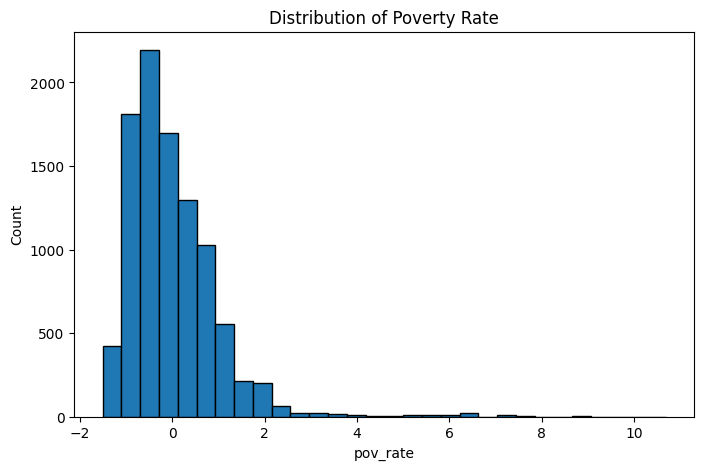

In [16]:
# Hist for target variable
plt.figure(figsize = (8, 5))
plt.hist(df['pov_rate'], bins=30, edgecolor='black')
plt.title('Distribution of Poverty Rate')
plt.xlabel('pov_rate')
plt.ylabel('Count')
plt.show()

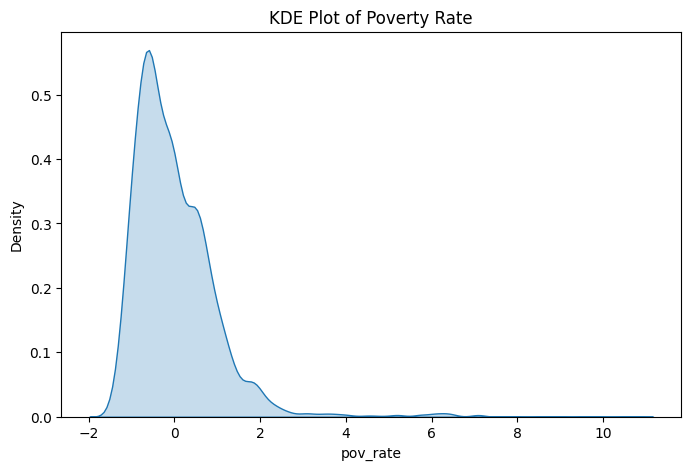

In [17]:
# kernel density plot
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='pov_rate', fill=True)
plt.title('KDE Plot of Poverty Rate')
plt.xlabel('pov_rate')
plt.ylabel('Density')
plt.show()

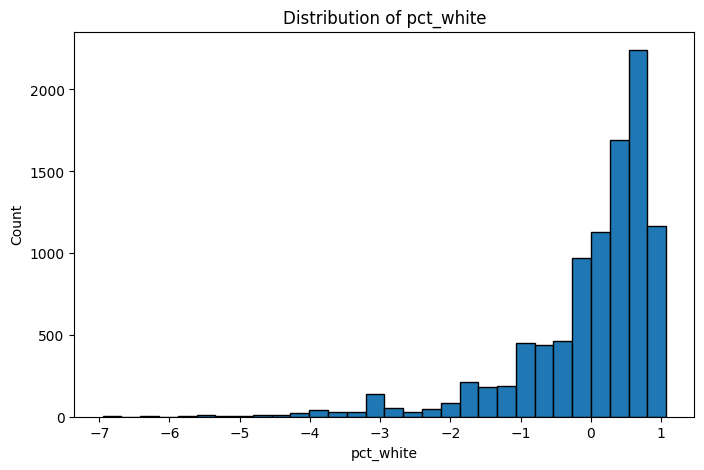

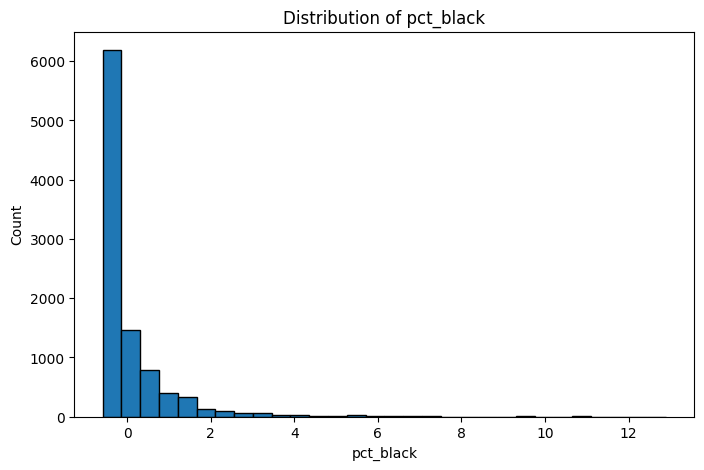

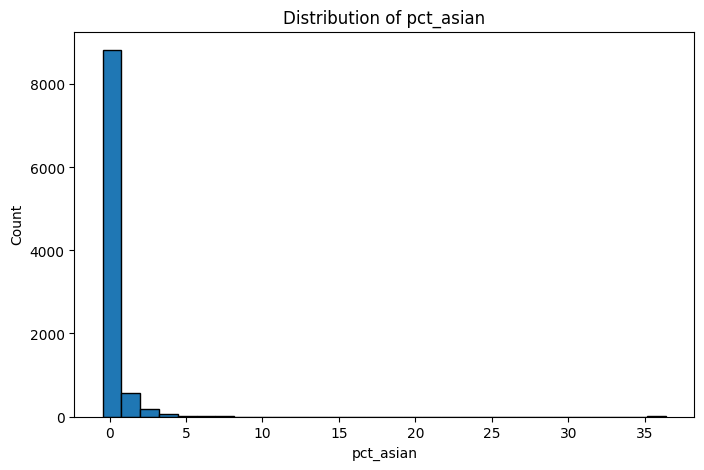

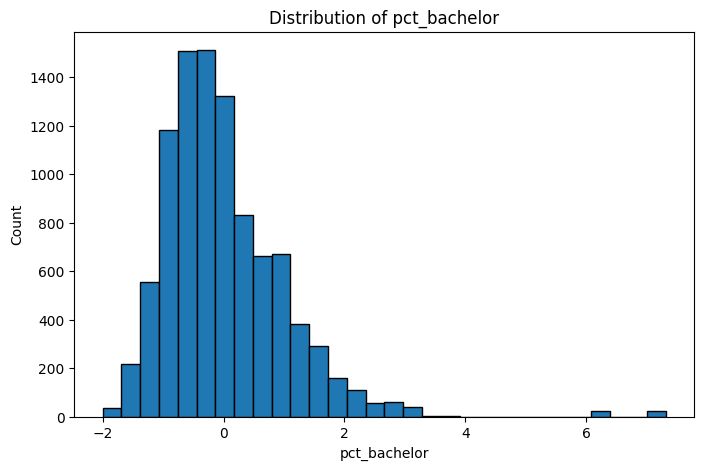

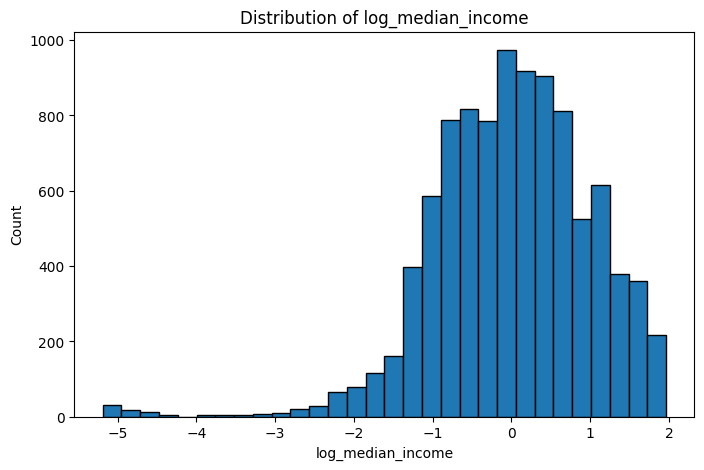

In [18]:
# other predictor variables
vars_to_plot = ['pct_white', 'pct_black', 'pct_asian', 'pct_bachelor', 'log_median_income']

for var in vars_to_plot:
    plt.figure(figsize=(8, 5))
    plt.hist(df[var], bins=30, edgecolor='black')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.show()

In [19]:
# double check with the skewness
df[vars_to_plot].skew()

pct_white            -2.132187
pct_black             4.214105
pct_asian            21.045695
pct_bachelor          1.888971
log_median_income    -0.835870
dtype: float64

In [20]:
# since the pct_black and pct_asian and white, their abs value over 1, we should consider perform the log-transform
df['pct_white_as'] = np.arcsin(np.sqrt(df['pct_white'].clip(0, 1)))
df['pct_black_as'] = np.arcsin(np.sqrt(df['pct_black'].clip(0, 1)))
df['pct_asian_as'] = np.arcsin(np.sqrt(df['pct_asian'].clip(0, 1)))
df['pct_bachelor_as'] = np.arcsin(np.sqrt(df['pct_bachelor'].clip(0, 1)))


print("\nSkewness after arcsine sqrt transform:")
print(df[['pct_white_as','pct_black_as','pct_asian_as', 'pct_bachelor_as']].skew())


Skewness after arcsine sqrt transform:
pct_white_as       0.143716
pct_black_as       1.645356
pct_asian_as       1.864852
pct_bachelor_as    1.063127
dtype: float64


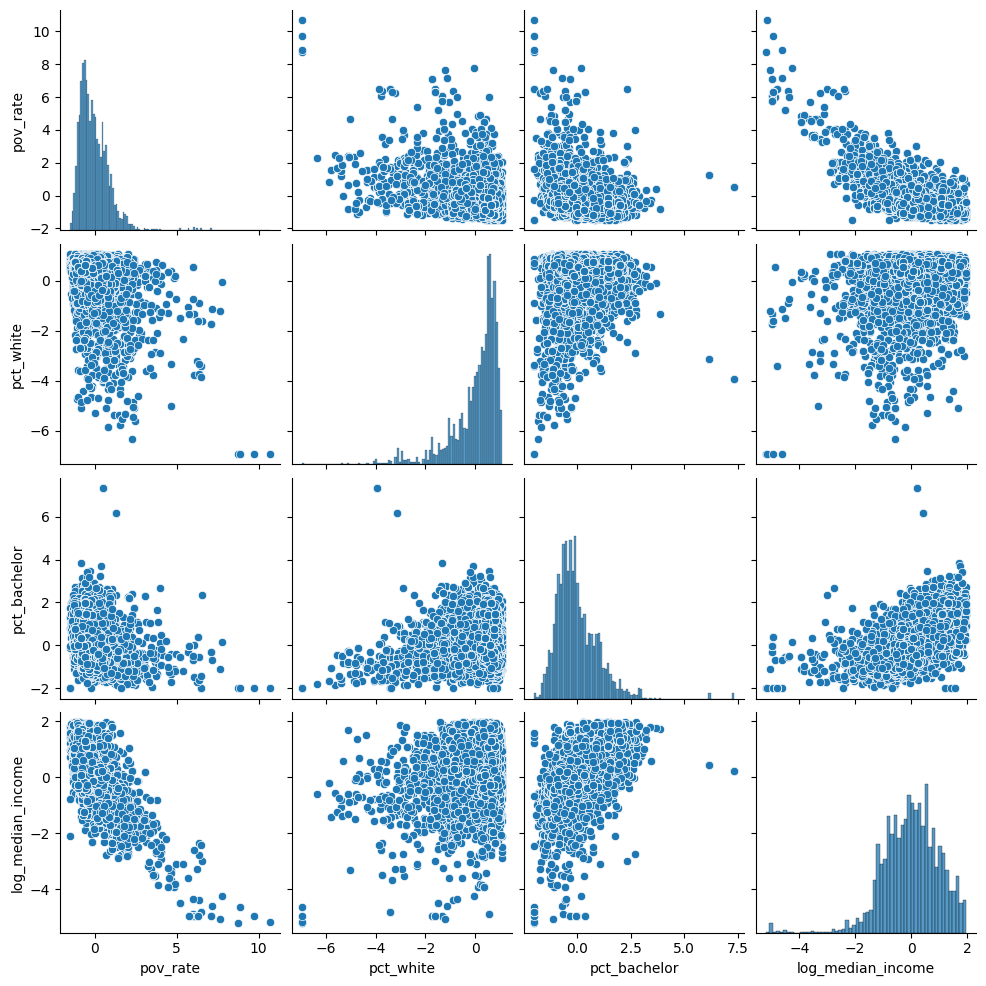

In [21]:
# comparison 
sns.pairplot(df[['pov_rate', 'pct_white', 'pct_bachelor', 'log_median_income']])
plt.show()

#### Correlation Analaysis

Correlation Matrix:
                   GEOID  total_popE  total_popM  race_whiteE  race_whiteM  \
GEOID           1.000000    0.133893   -0.101790     0.194368    -0.039083   
total_popE      0.133893    1.000000    0.446597     0.956235     0.529546   
total_popM     -0.101790    0.446597    1.000000     0.340111     0.928159   
race_whiteE     0.194368    0.956235    0.340111     1.000000     0.467421   
race_whiteM    -0.039083    0.529546    0.928159     0.467421     1.000000   
race_blackE     0.006160    0.084629    0.089015    -0.010688     0.070027   
race_blackM    -0.031295    0.113876    0.180789     0.025464     0.157697   
race_asianE    -0.097628    0.035981    0.012501    -0.034468     0.006205   
race_asianM    -0.131719    0.078666    0.124759     0.001710     0.122687   
median_incomeE  0.024419    0.119839    0.070156     0.151878     0.096202   
median_incomeM -0.148944   -0.186724    0.121678    -0.201869     0.114703   
pov_universeE   0.128573    0.991135    0.45

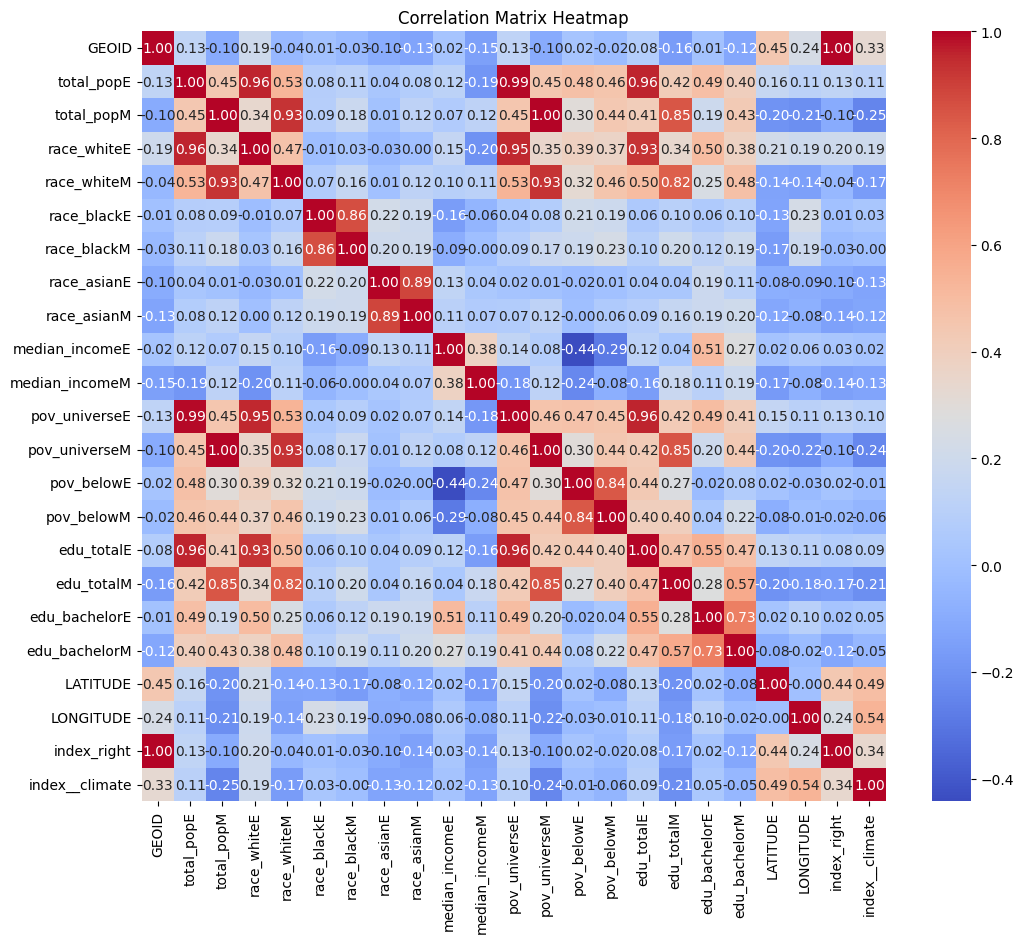

In [25]:
# Compute correlation matrix for numeric features
corr_matrix = df[numerical_cols].corr()

# Display correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

# 2B. Heatmap Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

## Boxplot to see whether the distribution of features in high pov and low pov rate have distinct places.
Therefore, we could use the features that are very different among two class to 

In [24]:
## 回来看看图
features = [
    'pct_white_as', 
    'pct_black_as',
    'pct_asian_as', 
    'pct_bachelor_as', 
    'log_median_income'
]

for col in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x='high_pov', y=col)
    plt.title(f"{col} by High Poverty (0 vs. 1)")
    plt.xlabel("High Poverty (0=No, 1=Yes)")
    plt.ylabel(col)
    plt.show()

ValueError: Could not interpret value `high_pov` for `x`. An entry with this name does not appear in `data`.

<Figure size 600x400 with 0 Axes>

It seems like except log_median_income, the distributions for education levels, races are very different across these two classes (high poverty or not).
Since it does have the different but not distinct one for log_median_income, we might still use this variable as our feature

# Regression Models

## Linear Regression

In [26]:
# features and fit the model
features = [
    'pct_white_as', 
    'pct_black_as', 
    'pct_asian_as', 
    'pct_bachelor_as', 
    'log_median_income'
]

X = df[features].copy()
y = df['pov_rate'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [27]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [28]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print("Linear Regression Performance")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

Linear Regression Performance
MSE: 0.4592
RMSE: 0.6776
R^2: 0.5292


### Ridge Regression with Grid Search

In [29]:
ridge = Ridge()
param_grid = {'alpha': [1, 5, 6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 20, 50]}
ridge_cv = GridSearchCV(ridge, param_grid, scoring = 'neg_mean_squared_error', cv = 5, n_jobs = -1)
ridge_cv.fit(X_train, y_train)

best_ridge = ridge_cv.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = mse_ridge**0.5
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge L2 Regularization after Linear regression Performance")
print(f"Best Ridge alpha: {ridge_cv.best_estimator_}")
print(f"Ridge MSE on test: {mse_ridge:.4f}")
print(f"Ridge RMSE on test: {rmse_ridge:.4f}")
print(f"Ridge R^2 on test: {r2_ridge:.4f}")

Ridge L2 Regularization after Linear regression Performance
Best Ridge alpha: Ridge(alpha=15)
Ridge MSE on test: 0.4592
Ridge RMSE on test: 0.6776
Ridge R^2 on test: 0.5292


why the l2 regularization not improve performance?
1. i think the regularization is penalizing the complexity of the original model to achieve the better performance, maybe the default linear regression has achiever the near optimum for these varaibles? (seems like there is no highly multicolinearity issue or overfitting issue)
2. alpha is high enough since i originally test the 50 and 100, but the best performance is when alpha is lower 50, therefore, i shrinked the alpha into lower than 50, after few times of trials, the best alpha is 15

Maybe we could try lasso to see whether it could improve the interpretability of the model

In [31]:
lasso = Lasso()
param_grid = {'alpha': [0.00001, 0.00005, 0.0001, 0.0005, 0.0008, 0.001, 0.005, 0.1, 1, 5, 10]}
lasso_cv = GridSearchCV(lasso, param_grid, scoring= 'neg_mean_squared_error', cv = 5, n_jobs = -1)
lasso_cv.fit(X_train, y_train)

best_lasso = lasso_cv.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = mse_lasso ** 0.5
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso L1 Regularization after Linear regression Performance")
print(f"Best Lasso alpha: {lasso_cv.best_estimator_}")
print(f"Lasso MSE on test: {mse_lasso:.4f}")
print(f"Lasso RMSE on test: {rmse_lasso:.4f}")
print(f"Lasso R^2 on test: {r2_lasso:.4f}")

Lasso L1 Regularization after Linear regression Performance
Best Lasso alpha: Lasso(alpha=1e-05)
Lasso MSE on test: 0.4592
Lasso RMSE on test: 0.6776
Lasso R^2 on test: 0.5292


It seems like L1 got the same result, that has proved my first point above. Lets stick with the linear model, but otherwise, consider the interaction and polynominals to capture the non-linearity in linear model

### Polynominals

In [32]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)
poly_model = LinearRegression().fit(X_poly_train, y_train)
print("R^2 with polynomial features before L2", poly_model.score(X_poly_test, y_test))
ridge_poly = Ridge()
ridge_poly.fit(X_poly_train, y_train)
y_pred_poly = ridge_poly.predict(X_poly_test)
print("R^2 with polynomial features after L2:", r2_score(y_test, y_pred_poly))

R^2 with polynomial features before L2 0.5949859255319545
R^2 with polynomial features after L2: 0.5950831897410882


By setting degree is 2, we include all terms up to power for each variables, and across terms for each term. And by setting interaction_only = False, we could examine the squared terms for each feature, and interaction terms. It seems like the interpretability has been increased, there is non-linear pattern that we havent include in our model. In order to boost our model, we might consider more features.

### The different test_size might affect the performance

In [33]:
# increase the test_size / we should loop this progress
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
    X, y, test_size=0.5, random_state=42
)

lr = LinearRegression()
lr.fit(X_train_n, y_train_n)

y_pred_n = lr.predict(X_test_n)

In [34]:
mse = mean_squared_error(y_test_n, y_pred_n)
rmse = mse**0.5
r2 = r2_score(y_test_n, y_pred_n)

print("Linear Regression Performance")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

Linear Regression Performance
MSE: 0.4672
RMSE: 0.6836
R^2: 0.5031


seems like the increase test_size will increase the test error, we might want to decrease the test_size slightly (since 0.2 is low enough, further decrease will affect the performance of test part's accruarcy).

In [35]:
# increase the test_size / we should loop this progress
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
    X, y, test_size=0.15, random_state=42
)

lr = LinearRegression()
lr.fit(X_train_n, y_train_n)

y_pred_n = lr.predict(X_test_n)

In [36]:
mse = mean_squared_error(y_test_n, y_pred_n)
rmse = mse**0.5
r2 = r2_score(y_test_n, y_pred_n)

print("Linear Regression Performance")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

Linear Regression Performance
MSE: 0.4766
RMSE: 0.6904
R^2: 0.5185


### Kfold Cross Validation with LR
This step provides a more stable and less split depedent estimate of how well our model generatlizes compared to a single train/test split

In [37]:
linreg_cv = LinearRegression()

# Simulate 5-fold cross_validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scorer = make_scorer(r2_score)
scores = cross_val_score(linreg_cv, X, y, cv=kf, scoring=r2_scorer)

print(f"Cross-validation R^2 scores: {scores}")
print(f"Average CV R^2: {scores.mean():.4f}")

Cross-validation R^2 scores: [0.52917851 0.50048485 0.4964349  0.5506258  0.56645279]
Average CV R^2: 0.5286


In [38]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', Ridge())  # Ridge is a good choice here since polynomial features can lead to multicollinearity and overfitting
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=kf, scoring='r2')

print("Pipeline with Polynomial Features CV R^2 scores:", scores)
print(f"Average CV R^2: {scores.mean():.4f}")

Pipeline with Polynomial Features CV R^2 scores: [0.59498365 0.583123   0.57172709 0.64501427 0.67418194]
Average CV R^2: 0.6138


Eventually, the performance of the model has increased, and the reason why we should use 5-fold cross-validation (with the ridge regularization):
1. this method splits the dataset into 5 parts, and with the model is trained 5 times, each time using a different fold as the validation set and the remaining folds as the training set. It could give us the several R^2 scores, providing a more robust estimate of the model's performance on unseen data compared to a single train_test split.
2. it could also mitigate the overfitting and data split bias, even though at the very beginning our model just too simple, with the l2 regularization, penalizing the complexity of the model

## Linear Regression -- Expand the features
Since at the EDA step, we also have noticed some of the features are worth to be included in our model, for exmaple, the health variables

In [ ]:
features = [
    'pct_white_as', 
    'pct_black_as', 
    'pct_asian_as', 
    'pct_bachelor_as', 
    'log_median_income',
    # 加你新加上的variable，这里需要做outlier removal / dropna
]

X = df[features].copy()
y = df['pov_rate'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Explore the non-linear model (Random Forest)

In [39]:
## Randome Forest

rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = rf_mse**0.5
rf_r2 = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print(f"MSE: {rf_mse:.4f}")
print(f"RMSE: {rf_rmse:.4f}")
print(f"R^2: {rf_r2:.4f}")

Random Forest Performance:
MSE: 0.1939
RMSE: 0.4403
R^2: 0.8012


It seems like the non-linear model will better find a solution in this case, therefore, we might consider there is multiconlinearity issue right here.

However, for the n_estimators, we could adjust the number of decision tress to different values, and other paramters for example, the max_depth, min_sample_split, min_samples_leaf, bootstrap to see which one get the best performance

In [55]:
param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

rf_model = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20, ## number of different parameter settings to try on
    scoring="r2",
    cv=5,
    random_state=42,
    n_jobs=-1 # we are using all the avaliable CPU cores
)

random_search.fit(X_train, y_train) # we still using the original X_train and y_train because the 0.2 split is the best performance

print("Best parameters found:", random_search.best_params_)
print("Best R^2 (on 5-fold CV):", random_search.best_score_)

Best parameters found: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Best R^2 (on 5-fold CV): 0.7846825247445941


In [57]:
# then we should evaluate on the test set
best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("Test MSE of best RF:", mse_best_rf)
print("Test R^2 of best RF:", r2_best_rf)

Test MSE of best RF: 0.17729847241373303
Test R^2 of best RF: 0.8244218596110404


Well, it seems like after adjusting the parameters, the accuracies have dropped, therefore, we might just stick with the original (default) random forest model.

## Logistic Regression

In [58]:
## accroding to the research, over 12.4% will be considered as high poverty rate (here we assume 20%)
df['high_pov'] = (df['pov_rate'] > 0.2).astype(int)

X_cls = df[features]
y_cls = df['high_pov']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size = 0.2, random_state=42
)

logreg = LogisticRegression(max_iter = 1000)
param_grid_log = {'C': [0.01, 0.05, 0.08, 0.1, 0.2, 0.5, 0.8, 1, 5]}
logreg_cv = GridSearchCV(logreg, param_grid_log, scoring = 'f1', cv = 5, n_jobs = -1)
logreg_cv.fit(X_train_cls, y_train_cls)

best_logreg = logreg_cv.best_estimator_
y_pred_cls = best_logreg.predict(X_test_cls)

acc = accuracy_score(y_test_cls, y_pred_cls)
prec = precision_score(y_test_cls, y_pred_cls)
rec = recall_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls)

print(f"Best Logistic Regression params: {logreg_cv.best_estimator_}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

Best Logistic Regression params: LogisticRegression(C=0.2, max_iter=1000)
Accuracy:  0.7707
Precision: 0.7278
Recall:    0.5483
F1 Score:  0.6254


### Explore the max_iter parameters

In [ ]:
# Train Logistic Regression with more iterations
logreg_poly = LogisticRegression(max_iter=5000)  # Increase max_iter

logreg_poly_cv = GridSearchCV(logreg, param_grid_log, scoring = 'f1', cv = 5, n_jobs = -1)
logreg_poly_cv.fit(X_poly_train, y_train_cls)

# Evaluate performance again
best_logreg = logreg_poly_cv.best_estimator_
y_pred_cls = best_logreg.predict(X_poly_test)

acc = accuracy_score(y_test_cls, y_pred_cls)
prec = precision_score(y_test_cls, y_pred_cls)
rec = recall_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls)

print( f"Logistic regression with polynomial feature")
print(f"Best Logistic Regression params: {logreg_cv.best_estimator_}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

even though the accuracy and F1 score have decreased, the recall increase, indicating that 1000 iterations might be the best performance here, but we can consider to expand the limit of iterations to slight increase the recall.

### Oversampling

In [83]:
# Perform the resampling method, trying to maximize the accurarcy:
# 先用oversampling 后面在undersampling， compare他妈的accuracies （这个accuracies我们或许需要不止用mse这些，可能也要用f1 score或者confusion matrix）

steps = [
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000))  # final estimator
]

pipe_smote = Pipeline(steps=steps)



In [84]:
# we still have to test which c will be the best match in this case
param_grid_smote = {
    'logreg__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scorer = make_scorer(f1_score, pos_label=1)

In [85]:
# refit the model
grid_smote = GridSearchCV(
    pipe_smote, 
    param_grid=param_grid_smote, 
    scoring=f1_scorer, 
    cv=cv, 
    n_jobs=-1
)

grid_smote.fit(X_train_cls, y_train_cls)

print("Best parameters (SMOTE + LogisticRegression):", grid_smote.best_params_)
print("Best mean F1 score (CV):", grid_smote.best_score_)

Best parameters (SMOTE + LogisticRegression): {'logreg__C': 0.05}
Best mean F1 score (CV): 0.679401186992448


In [86]:
# Evaluate on the test set
best_smote_model = grid_smote.best_estimator_
y_pred_smote_test = best_smote_model.predict(X_test_cls)

acc_o = accuracy_score(y_test_cls, y_pred_smote_test)
prec_o = precision_score(y_test_cls, y_pred_smote_test)
rec_o = recall_score(y_test_cls, y_pred_smote_test)
f1_o = f1_score(y_test_cls, y_pred_smote_test)

print("\nPerformance on Test Set (Oversampling via SMOTE + LogReg):")
print(f"Accuracy:  {acc_o:.4f}")
print(f"Precision: {prec_o:.4f}")
print(f"Recall:    {rec_o:.4f}")
print(f"F1 Score:  {f1_o:.4f}")


Performance on Test Set (Oversampling via SMOTE + LogReg):
Accuracy:  0.7474
Precision: 0.6126
Recall:    0.7637
F1 Score:  0.6798


Accurarcy and precision decrease
recall and F1 score increase

It seems like the result reveals that

### Undersampling

In [87]:
steps = [
    ('undersample', NearMiss(version=1)),
    ('logreg', LogisticRegression(max_iter=1000))
]
pipe_nearmiss = Pipeline(steps=steps)

param_grid_nearmiss = {
    'logreg__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 5]
}

# set up the gridsearchcv using the same cv splitter and f1 scorer
grid_nearmiss = GridSearchCV(
    pipe_nearmiss, 
    param_grid=param_grid_nearmiss, 
    scoring='f1', 
    cv=cv, 
    n_jobs=-1
)

grid_nearmiss.fit(X_train_cls, y_train_cls)

print("Best parameters (NearMiss + LogisticRegression):", grid_nearmiss.best_params_)
print("Best mean F1 score (CV):", grid_nearmiss.best_score_)

Best parameters (NearMiss + LogisticRegression): {'logreg__C': 0.01}
Best mean F1 score (CV): 0.6556365271574665


In [88]:
# evaluate on the test set
best_nearmiss_model = grid_nearmiss.best_estimator_
y_pred_nearmiss_test = best_nearmiss_model.predict(X_test_cls)

acc_u = accuracy_score(y_test_cls, y_pred_nearmiss_test)
prec_u = precision_score(y_test_cls, y_pred_nearmiss_test)
rec_u = recall_score(y_test_cls, y_pred_nearmiss_test)
f1_u = f1_score(y_test_cls, y_pred_nearmiss_test)

print("\nPerformance on Test Set (Undersampling via NearMiss + LogReg):")
print(f"Accuracy:  {acc_u:.4f}")
print(f"Precision: {prec_u:.4f}")
print(f"Recall:    {rec_u:.4f}")
print(f"F1 Score:  {f1_u:.4f}")


Performance on Test Set (Undersampling via NearMiss + LogReg):
Accuracy:  0.7505
Precision: 0.6253
Recall:    0.7223
F1 Score:  0.6703


## Cubic Spline Transformation
The reason why we are doing this is because, maybe there are inconsitencies among those variables, if we are spliting the high-pov rate is over 0.2, cubic spline transformation could capture more information

In [89]:
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import Pipeline

# we want to apply a spline to just one feature: 'log_median_income'
# we'll isolate that column and transform it, then concatenate with the others.

income_col = ['log_median_income']
other_cols = ['pct_white_as', 'pct_black_as', 'pct_asian_as', 'pct_bachelor_as']

from sklearn.compose import ColumnTransformer

spline = SplineTransformer(
    degree=3,      # cubic splines
    n_knots=5,     # how many knots to use
    include_bias=False
)

preprocessor = ColumnTransformer([
    ('spline_income', spline, income_col),
    ('other_features', 'passthrough', other_cols)
])

In [90]:
# now build a pipeline that does:
# 1) Spline transformation for 'log_median_income' + pass other features
# 2) Logistic Regression
logreg_spline_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

# we should do a grid search over the number of knots, and or the regularization 'C'
param_grid_spline = {
    'preprocess__spline_income__n_knots': [3, 5, 7],
    'logreg__C': [0.01, 0.1, 1, 10]
}

grid_spline = GridSearchCV(
    logreg_spline_pipeline, 
    param_grid_spline, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1
)

grid_spline.fit(X_train_cls, y_train_cls)

print("Best parameters (Spline + LogReg):", grid_spline.best_params_)
best_spline_model = grid_spline.best_estimator_

y_pred_spline = best_spline_model.predict(X_test_cls)

acc_spline = accuracy_score(y_test_cls, y_pred_spline)
prec_spline = precision_score(y_test_cls, y_pred_spline)
rec_spline = recall_score(y_test_cls, y_pred_spline)
f1_spline = f1_score(y_test_cls, y_pred_spline)

print("Logistic Regression with Spline Transform:")
print(f"  Accuracy:  {acc_spline:.4f}")
print(f"  Precision: {prec_spline:.4f}")
print(f"  Recall:    {rec_spline:.4f}")
print(f"  F1 Score:  {f1_spline:.4f}")

Best parameters (Spline + LogReg): {'logreg__C': 1, 'preprocess__spline_income__n_knots': 7}
Logistic Regression with Spline Transform:
  Accuracy:  0.7650
  Precision: 0.7000
  Recall:    0.5790
  F1 Score:  0.6338


# Result

## interpret model performance

### linear regression

In [94]:
# Create a DataFrame to display each feature with its corresponding coefficient
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": lr.coef_
})

sorted_coef_df = coef_df.sort_values(by="Coefficient", ascending=True)

print("Coefficients for each feature in the linear model:")
print(sorted_coef_df)

Coefficients for each feature in the linear model:
             Feature  Coefficient
4  log_median_income    -0.699859
0       pct_white_as    -0.288101
1       pct_black_as     0.048357
3    pct_bachelor_as     0.077904
2       pct_asian_as     0.079129


As we can see (and anticipated), income is the most important feature affecting poverty. This is intuitive as the more you earn, the less likely you would be in poverty, with all else being equal. However, when considering other factors, we also see that higher proportion of white race make it less likely to be poor tract, though the impact is less so than income. More Black and Asian means slightly more poverty but not by large. The race coefs make sense as white race is still the dominating race when it comes to socio-economic status. The percentage of bachelor degrees, surprisingly, has only small impact on poverty. This could be due to that obtaining a bachelor degree can be financially burdensome for some people, but not for others. Also, the benefit of bachelor may not be immediate (if you carry debt, you most likely will start to earn money in ten years rather than in one year). In short, bachelor may have both positive impact and negative impact towards poverty reduction, albeit the positive impact wins by a margin. 

### polynomial regression

In [91]:
# Get the feature names from the polynomial transformation
feature_names = poly.get_feature_names_out(input_features=X_train.columns)

# Create a DataFrame with the feature names and their corresponding coefficients
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": poly_model.coef_
})

# Alternatively, if you want to sort by the absolute value of the coefficients:
sorted_coef_abs_df = coef_df.reindex(coef_df["Coefficient"].abs().sort_values(ascending=False).index)
print("\nCoefficients sorted by absolute value (descending):")
print(sorted_coef_abs_df)


Coefficients sorted by absolute value (descending):
                              Feature  Coefficient
4                   log_median_income    -0.601887
2                        pct_asian_as    -0.353541
14                     pct_asian_as^2     0.287847
0                        pct_white_as    -0.284596
17                  pct_bachelor_as^2     0.234440
3                     pct_bachelor_as    -0.219898
12       pct_black_as pct_bachelor_as    -0.200298
1                        pct_black_as     0.198019
19                log_median_income^2     0.159576
8        pct_white_as pct_bachelor_as    -0.128516
11          pct_black_as pct_asian_as    -0.120862
6           pct_white_as pct_black_as    -0.115037
13     pct_black_as log_median_income     0.106061
7           pct_white_as pct_asian_as     0.074694
9      pct_white_as log_median_income     0.061819
15       pct_asian_as pct_bachelor_as    -0.038584
18  pct_bachelor_as log_median_income    -0.027882
5                      pct_wh

As we can see, income is still the most important feature when predicting poverty. Interestingly, when considering polynomial feature, asian is now the second important feature. One explanation is that the percentage of Asian does not affect poverty linearly. The census tract with high percentage of Asian is less poor, and the census tract with low percentage of Asian is more likely in poverty. This makes sense as wealthy Asians tend to cluster around a certain regions, such as around silicon valley area where a lot of Asians work for well-paid tech company. In contrast, in other areas where Asian are sparsely located, the minority status is likely to indicate higher poverty. Interestingly, black people with bachelor now has a higher impact on poverty reduction, suggesting that black people benefit more from bachelor degree. Asian does not benefit that much, as a large proportion of asians are immigrants engaging in small to medium scale business that does not require higher education degree.

### Random Forest

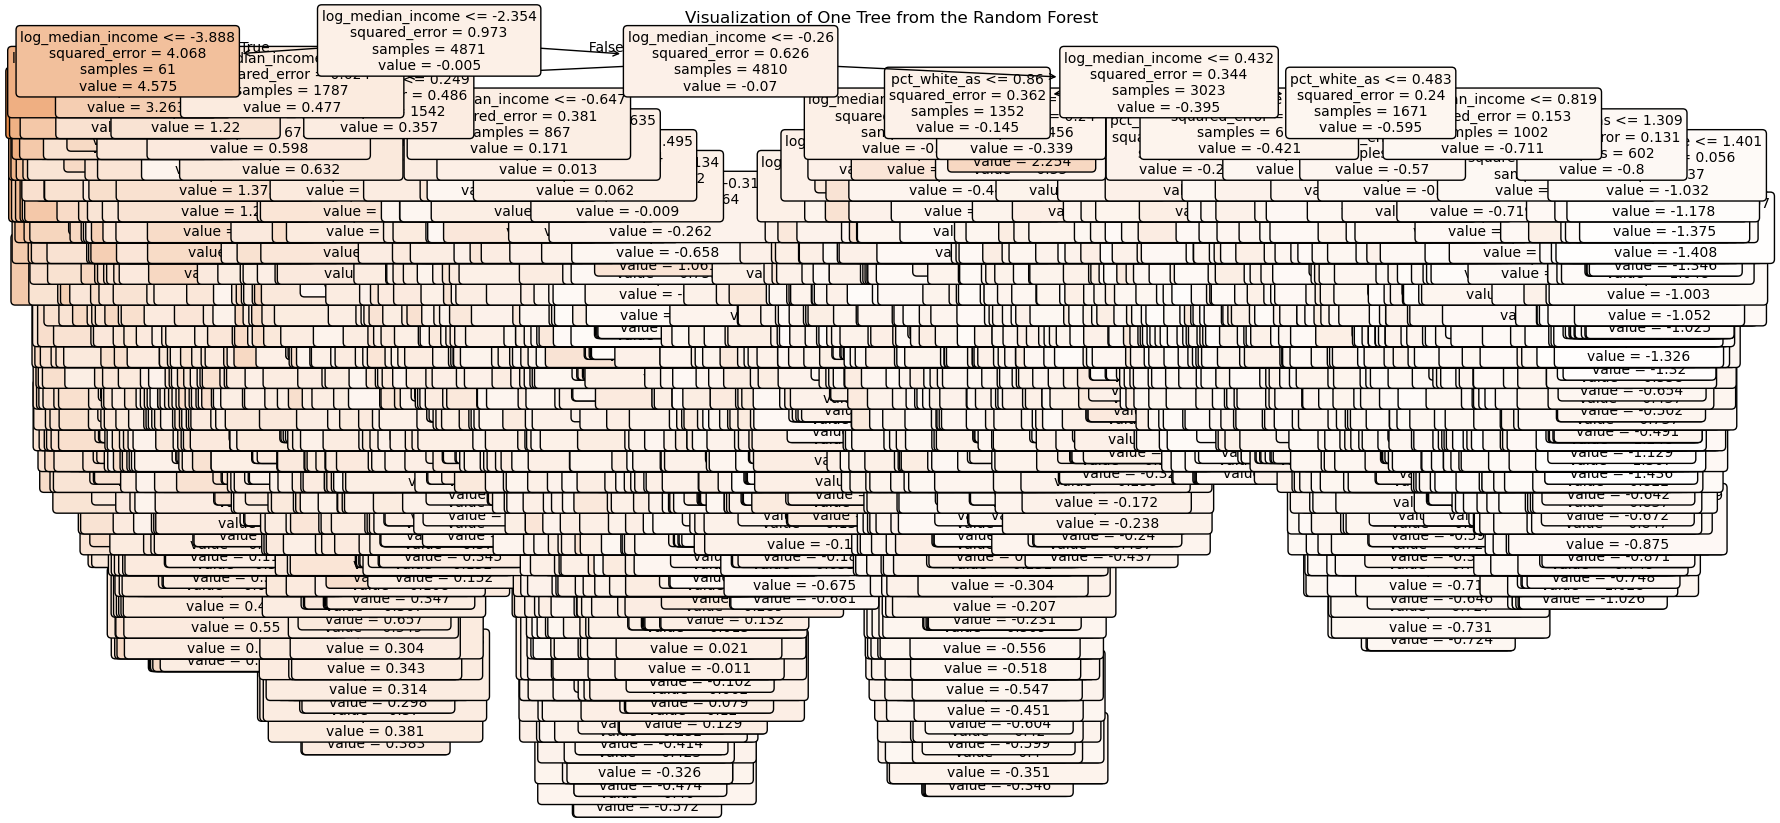

In [98]:
# Visualize the first tree in the forest
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], 
          feature_names=features, 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title("Visualization of One Tree from the Random Forest")
plt.show()

In [107]:
# alternative is to use graphviz, consult the pdf named Source.gv.pdf in the folder
from sklearn.tree import export_graphviz
import graphviz

# Select a single tree from the random forest (e.g., the first tree)
tree = rf.estimators_[0]

# Export the tree in Graphviz format
dot_data = export_graphviz(
    tree, 
    out_file=None,  # No file output, store in a variable
    feature_names=features,  # Feature names from dataset
    filled=True,  # Color the nodes based on prediction
    rounded=True, 
    special_characters=True
)

# Create a Graphviz object and display it
graph = graphviz.Source(dot_data)
graph.view()  # Opens the tree visualization in a viewer


'Source.gv.pdf'

In [122]:
# Get feature importance values from the trained Random Forest model
importances = rf.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    "Feature": features,  # List of feature names
    "Importance": importances
})

# Sort features by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Print the feature importances
print("Feature Importances in Random Forest:")
print(feature_importance_df)

Feature Importances in Random Forest:
             Feature  Importance
4  log_median_income    0.778239
0       pct_white_as    0.104360
2       pct_asian_as    0.041512
1       pct_black_as    0.039158
3    pct_bachelor_as    0.036731


A similar pattern still, but the income bears yet more importance

### logistics regression

In [121]:
coef_values = best_logreg.coef_[0] # get coefs
feature_names = X_train.columns  # Get feature names from training data

coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coef_values})

coef_df = coef_df.sort_values(by="Coefficient", ascending=True)

coef_df["Odds Ratio"] = np.exp(coef_df["Coefficient"])
print(coef_df)

             Feature  Coefficient  Odds Ratio
4  log_median_income    -1.555577    0.211068
0       pct_white_as    -0.884818    0.412789
2       pct_asian_as    -0.280513    0.755396
3    pct_bachelor_as    -0.225912    0.797788
1       pct_black_as    -0.112756    0.893369


Very similar to linear regression model, the most important feature in logistic regression is still income, followed by percentage of white people. Also very similarly, factor in more complex non-linear features is likely to further increase model performance.

## Error analysis

In [153]:
import error_analysis

### Linear regression standard

In [156]:
#import importlib
import error_analysis # a module that contains function for error analysis
#importlib.reload(error_analysis)  # Forces Python to reload the latest version

<module 'error_analysis' from '/Users/zhenningliu/Desktop/MACSS/MACS 30100/macs-30100-nickliu966/midterm_group_project/error_analysis.py'>

--- Linear Regression Error Analysis ---
Mean Absolute Error (MAE): 0.504
Mean Squared Error (MSE): 0.465
Root Mean Squared Error (RMSE): 0.682
R² Score: 0.540

Top 10 Error Cases:
          Actual  Predicted  Residual  Absolute Error
164423  7.776055   3.174539  4.601516        4.601516
175473  6.512906   2.345301  4.167604        4.167604
274525  7.655347   3.698232  3.957115        3.957115
131510  7.079086   3.760240  3.318846        3.318846
131508  7.079086   3.760240  3.318846        3.318846
287082  3.047758  -0.069564  3.117321        3.117321
287081  3.047758  -0.069564  3.117321        3.117321
52881   6.476491   3.457198  3.019293        3.019293
118687  4.087803   1.292693  2.795110        2.795110
163230  1.535269  -0.978671  2.513940        2.513940


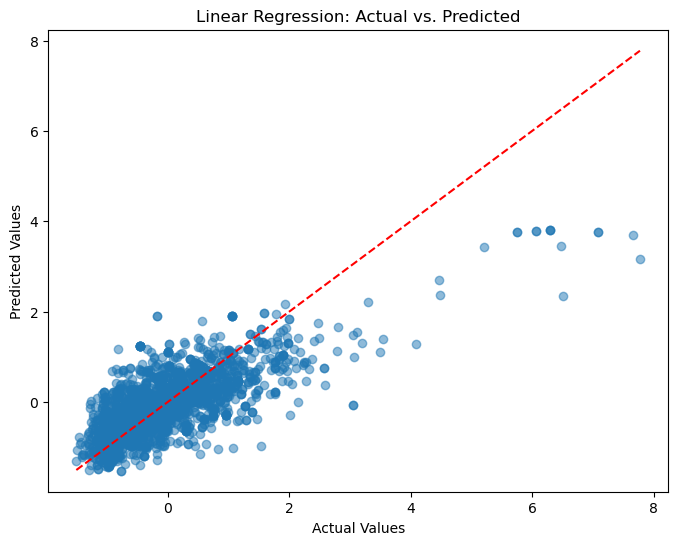

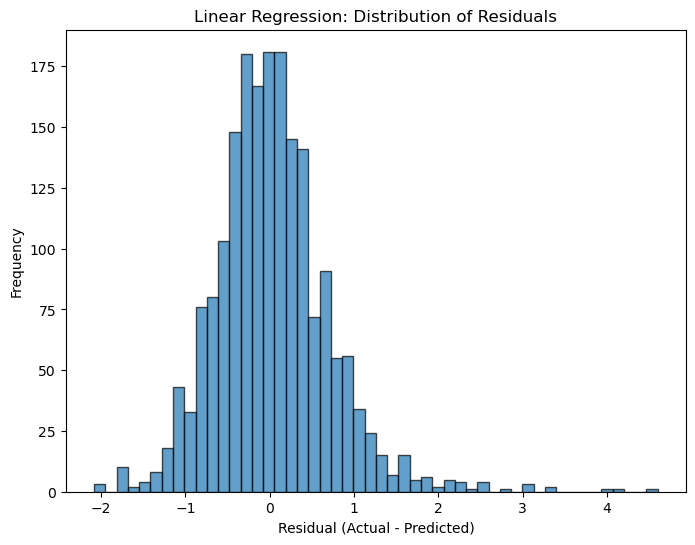

In [164]:
error_df_lr = error_analysis.analysis(lr, X_test, y_test, model_name="Linear Regression")

Most prominent errors are underprediction, which is that the model should predict a higher value but fails to do so. This is forseenable as linear model optimize for the mean trend (minimize MSE), does not take into account of the complex rationship between variables, failling to capture extremely high poverty cases. In other words, we see that the majority tracts have low-moderate poverty, the linear model can only learns the overall pattern from those cases, leading to failure to capture high poverty cases.

### Linear regression with L1

--- Linear Regression with L1 Error Analysis ---
Mean Absolute Error (MAE): 0.504
Mean Squared Error (MSE): 0.465
Root Mean Squared Error (RMSE): 0.682
R² Score: 0.540

Top 10 Error Cases:
          Actual  Predicted  Residual  Absolute Error
164423  7.776055   3.192944  4.583111        4.583111
175473  6.512906   2.366058  4.146847        4.146847
274525  7.655347   3.716859  3.938488        3.938488
131508  7.079086   3.776841  3.302245        3.302245
131510  7.079086   3.776841  3.302245        3.302245
287082  3.047758  -0.067234  3.114992        3.114992
287081  3.047758  -0.067234  3.114992        3.114992
52881   6.476491   3.480645  2.995846        2.995846
118687  4.087803   1.299103  2.788701        2.788701
163230  1.535269  -0.989896  2.525165        2.525165


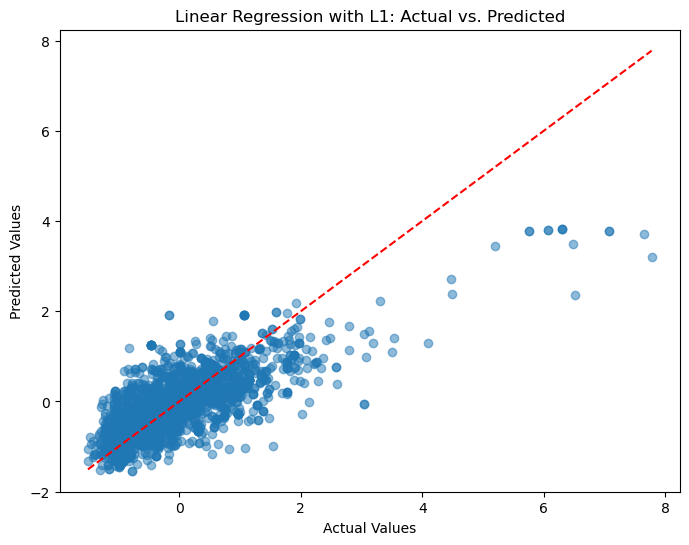

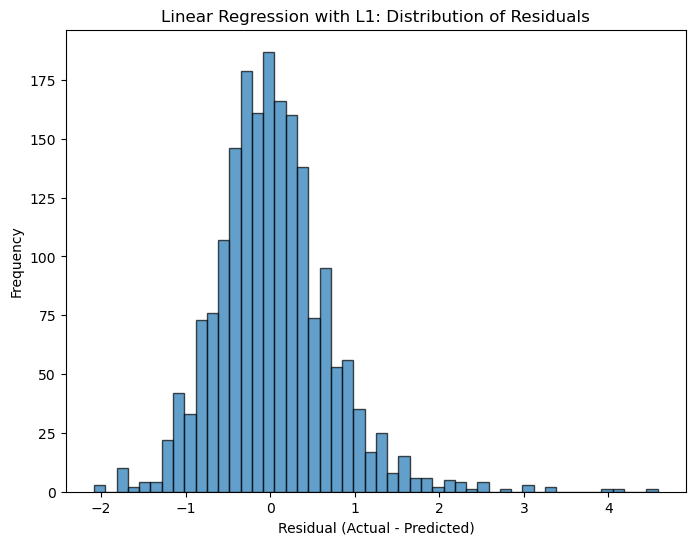

In [158]:
error_df_lasso = error_analysis.analysis(lasso_cv, X_test, y_test, model_name="Linear Regression with L1")

L1 is pretty much the same as standard linear model as we do not have many variables and the dataset is really large so hard to be overfit. The highest absolute error reduce though, ever so slightly.

### Linear regression with L2

--- Linear Regression with l2 Error Analysis ---
Mean Absolute Error (MAE): 0.504
Mean Squared Error (MSE): 0.465
Root Mean Squared Error (RMSE): 0.682
R² Score: 0.540

Top 10 Error Cases:
          Actual  Predicted  Residual  Absolute Error
164423  7.776055   3.187950  4.588105        4.588105
175473  6.512906   2.360371  4.152535        4.152535
274525  7.655347   3.711937  3.943410        3.943410
131508  7.079086   3.772435  3.306651        3.306651
131510  7.079086   3.772435  3.306651        3.306651
287082  3.047758  -0.067645  3.115403        3.115403
287081  3.047758  -0.067645  3.115403        3.115403
52881   6.476491   3.474418  3.002073        3.002073
118687  4.087803   1.297843  2.789960        2.789960
163230  1.535269  -0.989168  2.524438        2.524438


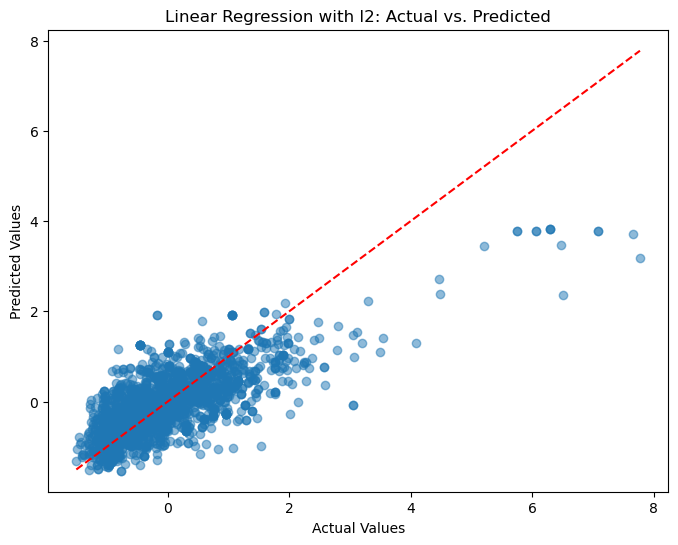

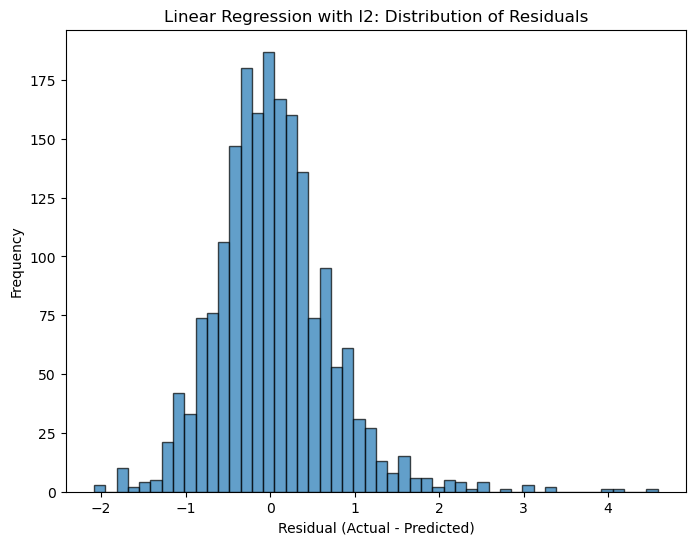

In [159]:
error_df_ridge = error_analysis.analysis(ridge_cv, X_test, y_test, model_name="Linear Regression with l2")

L2 is the same case with L1

### Polynomial regression

--- poly regression Error Analysis ---
Mean Absolute Error (MAE): 0.472
Mean Squared Error (MSE): 0.383
Root Mean Squared Error (RMSE): 0.619
R² Score: 0.621

Top 10 Error Cases:
          Actual  Predicted  Residual  Absolute Error
287081  3.047758  -0.146490  3.194248        3.194248
287082  3.047758  -0.146490  3.194248        3.194248
175473  6.512906   3.397844  3.115061        3.115061
164423  7.776055   4.955618  2.820437        2.820437
118687  4.087803   1.450379  2.637424        2.637424
176     2.012358  -0.570637  2.582994        2.582994
162032  2.587467   0.238300  2.349166        2.349166
224277  3.503001   1.185405  2.317595        2.317595
149005  3.541980   1.254844  2.287136        2.287136
122068 -0.171545   2.067181 -2.238726        2.238726


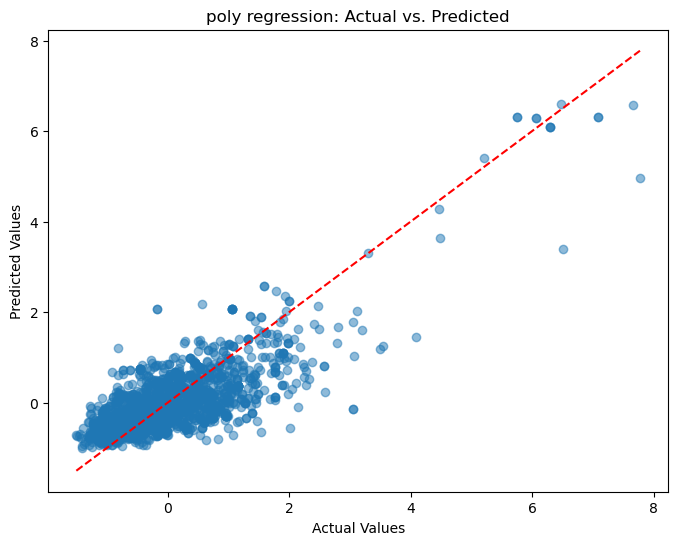

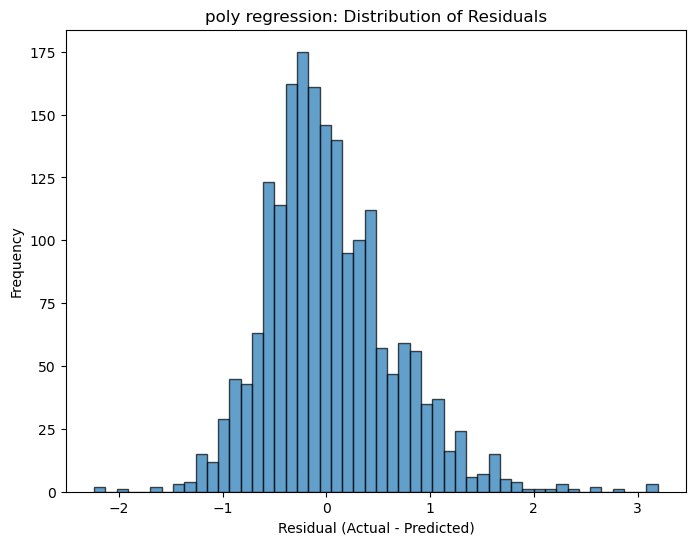

In [172]:
error_df_poly = error_analysis.analysis(poly_model, X_poly_test, y_test, model_name="poly regression")

### Polynomial regression with L2

--- Poly regression with L2 Error Analysis ---
Mean Absolute Error (MAE): 0.472
Mean Squared Error (MSE): 0.383
Root Mean Squared Error (RMSE): 0.619
R² Score: 0.621

Top 10 Error Cases:
          Actual  Predicted  Residual  Absolute Error
287082  3.047758  -0.151352  3.199110        3.199110
287081  3.047758  -0.151352  3.199110        3.199110
175473  6.512906   3.394596  3.118310        3.118310
164423  7.776055   4.955500  2.820555        2.820555
118687  4.087803   1.451094  2.636709        2.636709
176     2.012358  -0.570148  2.582506        2.582506
162032  2.587467   0.236978  2.350489        2.350489
224277  3.503001   1.184406  2.318595        2.318595
149005  3.541980   1.256372  2.285607        2.285607
122068 -0.171545   2.066845 -2.238390        2.238390


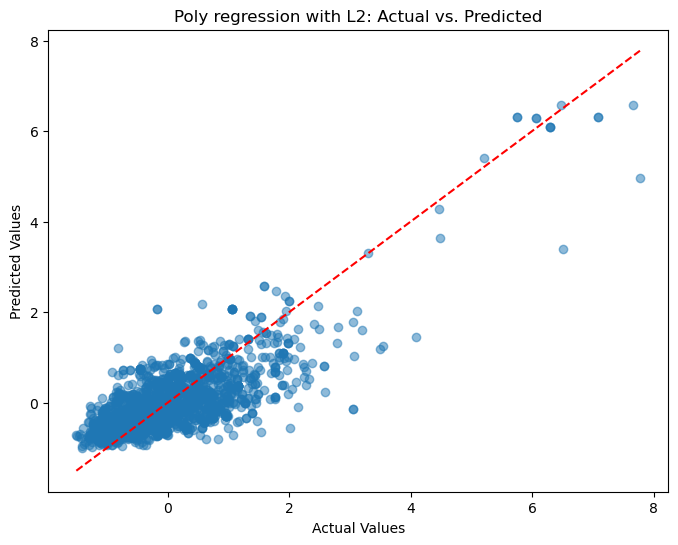

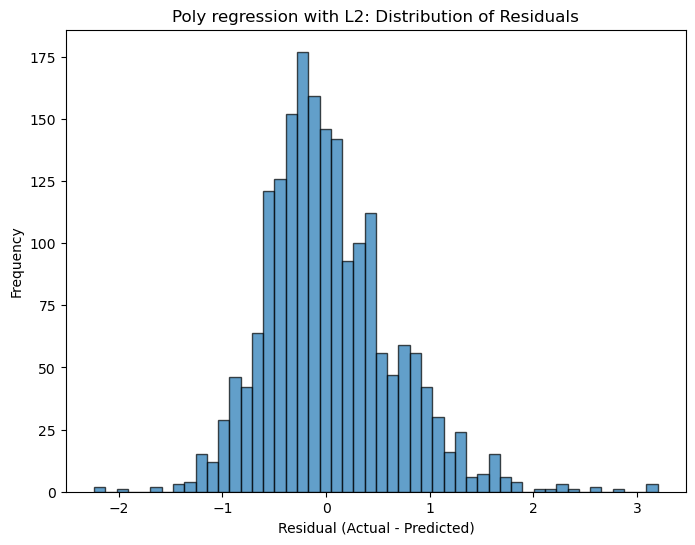

In [173]:
error_df_poly_ridge = error_analysis.analysis(ridge_poly, X_poly_test, y_test, model_name="Poly regression with L2")

The polynomial regression with a degree of 2 significantly increases the performance. Now the error is much reduced for high poverty cases, as indicated by most high-poverty cases pulled towards the perfect line. This is reasonable as polynomial regression accounts for complex interactions between variables. For example, poverty may decrease with income at a decreasing rate (logarithmic or quadratic trend), and the effect of race might interact with income and education, which linear regression cannot capture. Polynomial regression helps because it introduces squared and interaction terms, allowing the model to fit more complex patterns.

Next, we will explore different degree and found that a degree of 6 maximize the accuracy.

### Polynomial regression degree 6

--------After bumping degree to 6 without L2--------
--- poly regression Error Analysis ---
Mean Absolute Error (MAE): 0.439
Mean Squared Error (MSE): 0.360
Root Mean Squared Error (RMSE): 0.600
R² Score: 0.644

Top 10 Error Cases:
          Actual  Predicted  Residual  Absolute Error
164423  7.776055  13.059251 -5.283196        5.283196
52343   0.946614  -2.539411  3.486026        3.486026
149005  3.541980   0.713317  2.828662        2.828662
175473  6.512906   3.939545  2.573361        2.573361
188705  2.275446  -0.133246  2.408692        2.408692
184520  2.326345   0.039356  2.286989        2.286989
118687  4.087803   1.837290  2.250513        2.250513
131176 -1.083475   1.159997 -2.243472        2.243472
276054  0.932099   3.142804 -2.210706        2.210706
216731 -0.098673  -2.203756  2.105083        2.105083


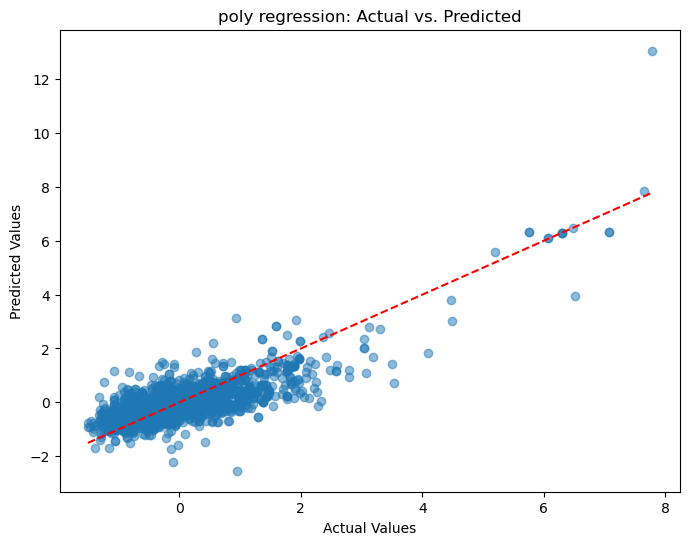

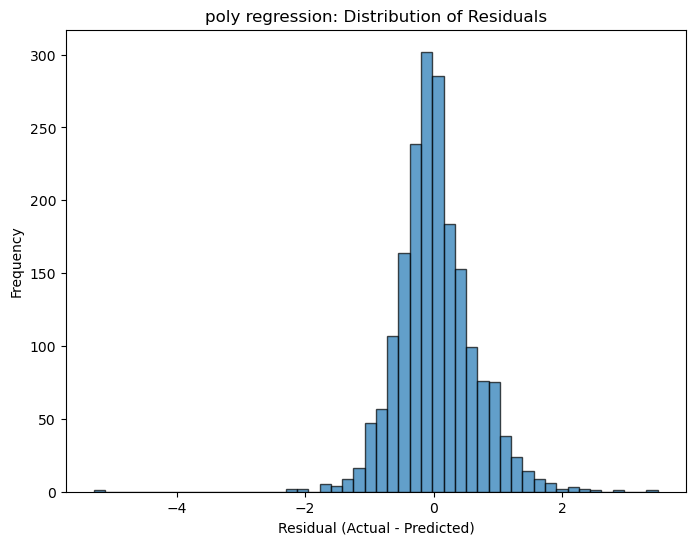

In [180]:
poly = PolynomialFeatures(degree=6, interaction_only=False, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)
poly_model = LinearRegression().fit(X_poly_train, y_train)
ridge_poly = Ridge()
ridge_poly.fit(X_poly_train, y_train)
y_pred_poly = ridge_poly.predict(X_poly_test)
print("--------After bumping degree to 6 without L2--------")
error_df_poly = error_analysis.analysis(poly_model, X_poly_test, y_test, model_name="poly regression")

### Polynomial regression degree 6 with L2

----------poly degree 6 with L2----------
--- Poly regression with L2 Error Analysis ---
Mean Absolute Error (MAE): 0.435
Mean Squared Error (MSE): 0.332
Root Mean Squared Error (RMSE): 0.576
R² Score: 0.671

Top 10 Error Cases:
          Actual  Predicted  Residual  Absolute Error
118687  4.087803   1.069819  3.017984        3.017984
149005  3.541980   1.128596  2.413384        2.413384
176     2.012358  -0.371992  2.384349        2.384349
108546 -0.822968   1.378566 -2.201533        2.201533
122244  3.071060   0.874271  2.196789        2.196789
164423  7.776055   5.579345  2.196710        2.196710
131176 -1.083475   1.074928 -2.158402        2.158402
224277  3.503001   1.395290  2.107710        2.107710
163230  1.535269  -0.547083  2.082352        2.082352
223365  2.140577   0.090477  2.050100        2.050100


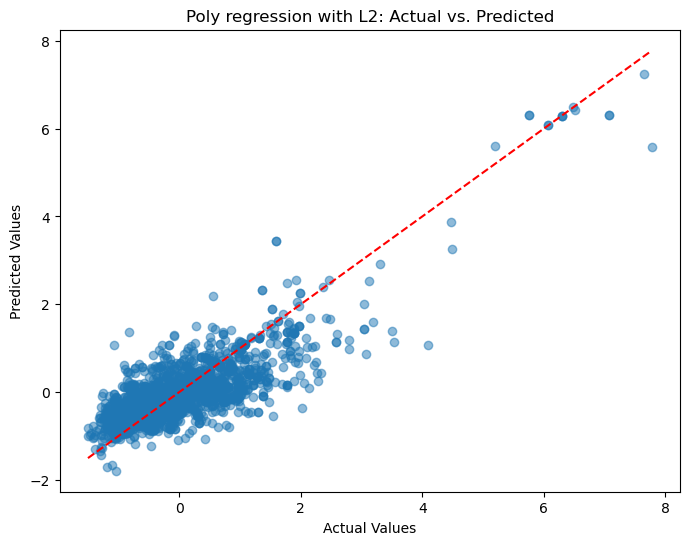

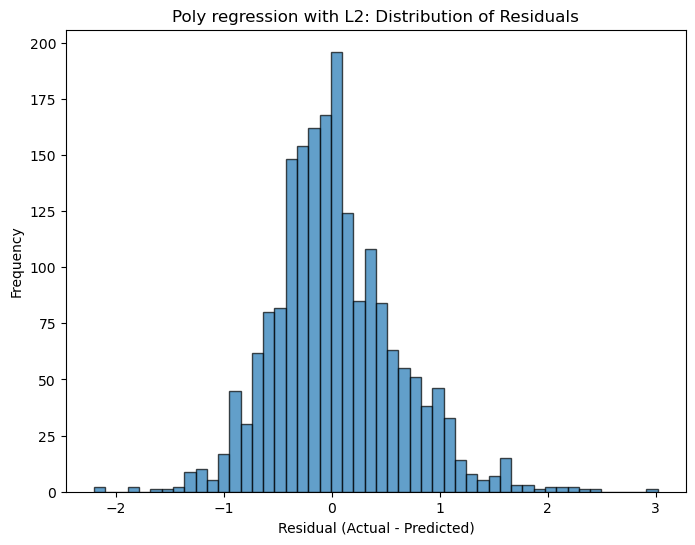

In [183]:
print("----------poly degree 6 with L2----------")
error_df_poly_ridge = error_analysis.analysis(ridge_poly, X_poly_test, y_test, model_name="Poly regression with L2")

As we can see, with a degree of 6 the model perform slightly better, but it also introduce outrageous error which predict much higher poverty than it should. This is reasonable as a degree of 6 will really explode the higher poverty cases. After L2 regularization, the extreme case is regulated and you can see the tract with a predicted poverty of 12 is much more normal.

### Random forest

--- Random Forest Error Analysis ---
Mean Absolute Error (MAE): 0.238
Mean Squared Error (MSE): 0.177
Root Mean Squared Error (RMSE): 0.421
R² Score: 0.825

Top 10 Error Cases:
          Actual  Predicted  Residual  Absolute Error
259680  1.923573   4.730988 -2.807415        2.807415
175473  6.512906   3.745483  2.767422        2.767422
149005  3.541980   1.048001  2.493978        2.493978
163230  1.535269  -0.722570  2.257839        2.257839
25000   1.991800   4.189873 -2.198073        2.198073
25001   1.991800   4.189873 -2.198073        2.198073
118687  4.087803   2.090739  1.997064        1.997064
164423  7.776055   5.886745  1.889309        1.889309
23480  -1.232062   0.623438 -1.855500        1.855500
60285  -1.257512   0.568908 -1.826420        1.826420


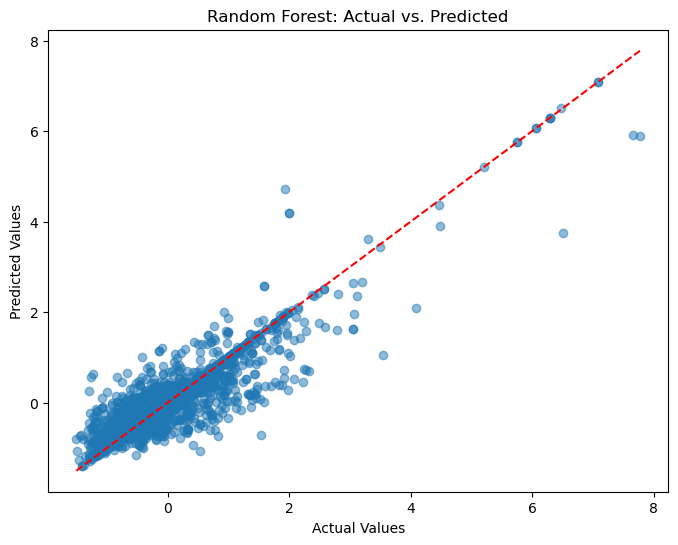

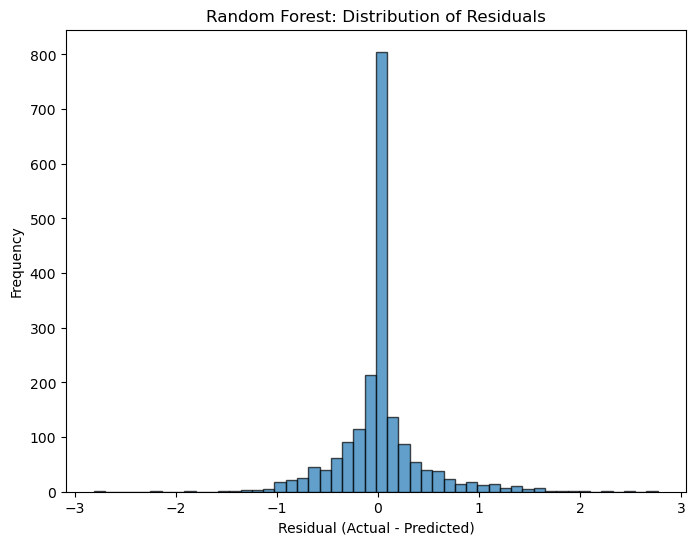

In [162]:
error_df_rf = error_analysis.analysis(rf, X_test, y_test, model_name="Random Forest")

- Learns localized effects: It can differentiate between low-poverty areas with high income vs. high-poverty areas with low income dynamically, which enables it to predict non-linear relationship between poverty and income as well as other variables.
- Compared to random roests, polynomial regression still assumes a smooth, continuous function—it struggles with sharp changes in poverty rates.
If poverty rates suddenly increase at certain income levels, tree-based models are better than polynomial regression.

### Logistic Regression

--- Logistic Regression (High Poverty Prediction) Error Analysis ---
Accuracy:  0.7707
Precision: 0.7278
Recall:    0.5483
F1 Score:  0.6254

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.83      1255
           1       0.73      0.55      0.63       673

    accuracy                           0.77      1928
   macro avg       0.76      0.72      0.73      1928
weighted avg       0.77      0.77      0.76      1928

Confusion Matrix:
[[1117  138]
 [ 304  369]]


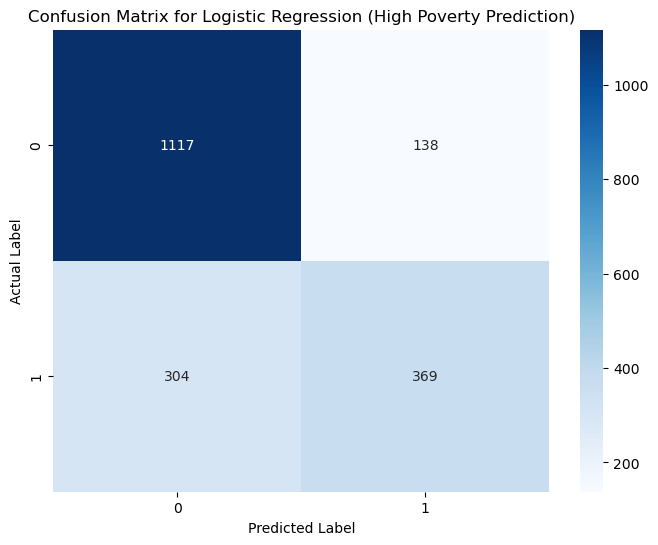

Total samples: 1928, Misclassified: 442
Examples of misclassified samples:
        Actual  Predicted  Correct
194327       1          0    False
68415        1          0    False
162080       1          0    False
197050       1          0    False
190261       1          0    False
             Feature  Coefficient  Odds Ratio
4  log_median_income    -1.555577    0.211068
0       pct_white_as    -0.884818    0.412789
2       pct_asian_as    -0.280513    0.755396
3    pct_bachelor_as    -0.225912    0.797788
1       pct_black_as    -0.112756    0.893369


In [163]:
# Now call the error analysis function:
results_df = error_analysis.analysis_logistic(
    best_logreg,
    X_test_cls,
    y_test_cls,
    model_name="Logistic Regression (High Poverty Prediction)"
)

coef_values = best_logreg.coef_[0] # get coefs
feature_names = X_train.columns  # Get feature names from training data

coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coef_values})

coef_df = coef_df.sort_values(by="Coefficient", ascending=True)

coef_df["Odds Ratio"] = np.exp(coef_df["Coefficient"])
print(coef_df)

Logistic regression disproportionately favors large coefficients, meaning features with small coefficients have little influence on predictions as the model is operated on an exponential scale.
This leads to false negatives when multiple weak predictors (e.g., race, education) should indicate high poverty, but none individually push the probability over 0.5.
The decision threshold (0.5) may amplify this issue, as weak signals fail to cross it, misclassifying some high-poverty areas as low poverty.
Lowering the threshold (e.g., to 0.4) may help capture more high-poverty cases and reduce false negatives.
Random Forest handles this better because it captures feature interactions and does not require any single predictor to dominate.